In [7]:
%run setup_PS_data.ipynb
import pandas as pd

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


Now loading mouse J048, run 32
This run has 1972 cells and 36460 frames
microcontroller trial starts occur on average nan ms from galvo trial starts
number of pre frames: 21, number of post frames 21
Shape new array : (1972, 274, 42)
(1972, 274, 42) (1972, 8, 42)
photo stim occurences: {0: 94, 1: 82, 2: 98}
Occurence table:
[[67. 27.]
 [42. 40.]
 [31. 67.]]


In [8]:
nonnan_trials = np.unique(np.where(~np.isnan(behaviour_trials))[1])
behaviour_trials = behaviour_trials[:, nonnan_trials, :]
photostim = photostim[nonnan_trials]
decision = decision[nonnan_trials]
trial_subsets = trial_subsets[nonnan_trials]

print(behaviour_trials.shape)  # all trials  (n_neurons x n_trials x n_times)
print(photostim.shape)  # photostim (0=no PS; 1=5-50 stim; 2=150 stim)
print(decision.shape)  # decision (0=no go; 1=go)
print(np.unique(trial_subsets))  # exact amount of PS neurons
print(filter_ps_array)  # time points outside of laser artefact
final_pre_gap_tp = np.where(np.diff(filter_ps_array) > 1)[0][0]
print(final_pre_gap_tp)
assert len(s1_bool) == behaviour_trials.shape[0]

(1972, 255, 42)
(255,)
(255,)
[  0   5  10  20  30  40  50 150]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
19


In [9]:
## Split data into train & test

include_150 = False  #NB: have not tried to implement this yet
n_split = 5
trial_times_use = filter_ps_array[(final_pre_gap_tp + 1):(final_pre_gap_tp + 6)]
n_trial_times_used = len(trial_times_use)

neurons_include = np.arange(behaviour_trials.shape[0])
# neurons_include = s2_bool
def fun_return_2d(data):  # fancy stuf
    return np.mean(data, 2)

if include_150 is False:
    trial_inds = np.where(photostim < 2)[0]
else:
    trial_inds = np.arange(len(photostim))
n_trials = len(trial_inds)
print(f'Total number of trials is {n_trials}. Number of splits is {n_split}')
    
data_use = behaviour_trials[neurons_include, :, :]
data_use = data_use[:, :, trial_times_use]
data_use = data_use[:, trial_inds, :]
data_use = fun_return_2d(data_use)
stand_scale = sklearn.preprocessing.StandardScaler()
data_use = stand_scale.fit_transform(data_use)

# sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=n_split, test_size=0.2)
sss = sklearn.model_selection.StratifiedKFold(n_splits=n_split)
# dict_predictions_test ={x: np.array([]) for x in ['pred_stim_test', 'pred_dec_test',
#                                                   'n_ps_test', 'dec_test']}
# dict_predictions_train ={x: np.array([]) for x in ['pred_stim_train', 'pred_dec_train',
#                                                   'n_ps_train', 'dec_train']}
print(np.sum(decision))
i_loop = 0
for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=photostim[trial_inds]):
    pass

    train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
    if i_loop == 0:
        print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

    train_labels = {'stim': photostim[trial_inds[train_inds]],
                    'dec': decision[trial_inds[train_inds]]}
    test_labels = {'stim': photostim[trial_inds[test_inds]],
                   'dec': decision[trial_inds[test_inds]]}
    print(np.sum(test_labels['dec']))
    detailed_ps_labels = trial_subsets[trial_inds]

    list_test = list(test_labels.keys())
    assert len(train_labels['dec']) == train_data.shape[1]
    assert len(test_labels['stim']) == test_data.shape[1]

    ## Train logistic regression model
    dec = {x: sklearn.linear_model.LogisticRegression(C=0.2).fit(
                X=train_data.transpose(), y=train_labels[x]) for x in list_test}

    pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
    pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}

    for x in list_test:
        dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
        dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
    dict_predictions_train['n_ps_train'] = np.concatenate((dict_predictions_train['n_ps_train'], detailed_ps_labels[train_inds]))
    dict_predictions_test['n_ps_test'] = np.concatenate((dict_predictions_test['n_ps_test'], detailed_ps_labels[test_inds]))
    dict_predictions_train['dec_train'] = np.concatenate((dict_predictions_train['dec_train'], train_labels['dec']))
    dict_predictions_test['dec_test'] = np.concatenate((dict_predictions_test['dec_test'], test_labels['dec']))
    i_loop += 1
print(f'length test: {len(dict_predictions_test["dec_test"])}')
df_prediction_train = pd.DataFrame(dict_predictions_train)
df_prediction_test = pd.DataFrame(dict_predictions_test)

Total number of trials is 164. Number of splits is 5
122
Shape train data (1972, 131), test data (1972, 33)
30
17
5
8
1
length test: 410


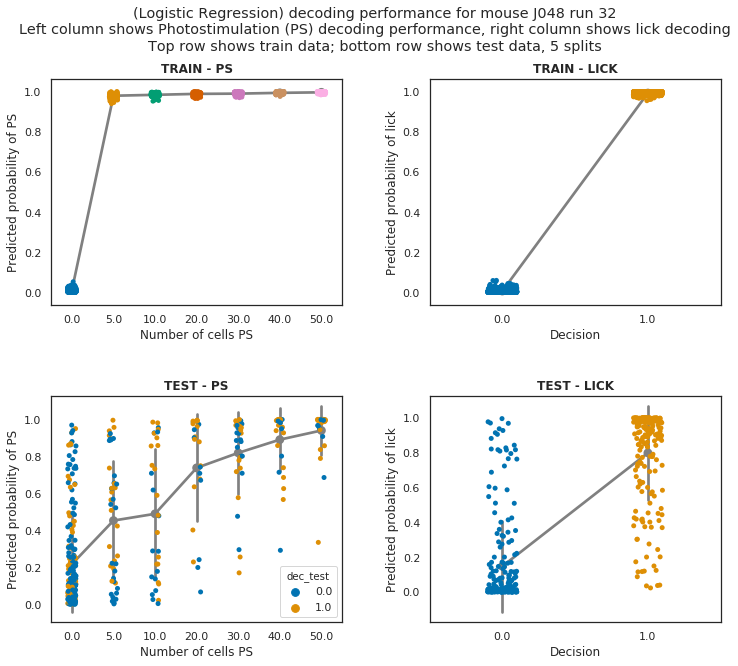

In [13]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

def plot_df_stats(df, xx, yy, hh, plot_line=True):
    if plot_line:
        sns.pointplot(data=df, x=xx, y=yy, color='grey', ci='sd')
    sns.stripplot(x=xx, y=yy, hue=hh, data=df)

plt.subplot(221)
plot_df_stats(df=df_prediction_train, xx='n_ps_train', yy='pred_stim_train', hh=None)
plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')

plt.subplot(222)
plot_df_stats(df=df_prediction_train, xx='dec_train', yy='pred_dec_train', hh=None)
plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')

plt.subplot(223)
plot_df_stats(df=df_prediction_test, xx='n_ps_test', yy='pred_stim_test', hh='dec_test')
plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')

plt.subplot(224)
plot_df_stats(df=df_prediction_test, xx='dec_test', yy='pred_dec_test', hh=None)
plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');

plt.suptitle(f'(Logistic Regression) decoding performance for mouse {mouse} run {run_number}\n' + 
             f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
             f'Top row shows train data; bottom row shows test data, {n_split} splits\n');

## ideas to improve / directions to go


#### Dynamic decoding performance

- Use only 1 time point; create summarising metric; plot metric as a function of time point (i.e. dynamic decoding performance). Lick vs PS different? => Pre vs post again? 


#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)

- different integration of time points per neuron? (i.e. separate, some other function etc)

- Try to find something that relates PS decoding to licking decoding

#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- We don't really find a difference between S1/S2 performance (-> large population?)